<a href="https://colab.research.google.com/github/rganeshsharma/AIML-FE/blob/master/ACE_MASK_DETECTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount the Shared Googe drive for dataset!

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install -q keras

Importing all the required Libraries

In [6]:
import os
import keras
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from os import listdir
import cv2
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

Mount the appropriate data and Load the images in appropriate data structures in your program, ready to be passed as input to the model for training. Consider input image size to be 64x64x3. [2 points]

In [7]:
def data_summary(main_path):
  withmask_path = main_path+'masked'
  withoutmask_path = main_path+'unmasked'
  # number of (images) that are in the the folder named 'masked' 
  m_pos = len(listdir('/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/train_validate/masked'))
  # number of (images) that are in the the folder named 'without_mask' 
  m_neg = len(listdir('/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/train_validate/unmasked'))
  # number of all examples
  m = (m_pos+m_neg)
  pos_prec = (m_pos* 100.0)/ m
  neg_prec = (m_neg* 100.0)/ m
  print(f"Number of examples: {m}")
  print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
  print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")    
augmented_data_path = '/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/trial1/augmented data1/'    
data_summary(augmented_data_path)

Number of examples: 1727
Percentage of positive examples: 51.36074116965837%, number of pos examples: 887
Percentage of negative examples: 48.63925883034163%, number of neg examples: 840


Create CNN model and provide train and test data to it

# New Section

In [8]:
early_stopage = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', 
    input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

Configure the CNN model (use keras tensorflow), an indicative (minimal) configuration is as below. Take activation function (A)=relu. Feel free to use standard values for anything that is not mentioned (eg, take pool size 2x2, filter size 3x3, and so on)

In [9]:
TRAINING_DIR = "/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/train_validate"
train_datagen = ImageDataGenerator(rescale=1.0/255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=10, target_size=(64, 64))
VALIDATION_DIR = "/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/test"
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=10, target_size=(64, 64))
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True,mode='auto')

Found 1727 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


Train the CNN model for E epoch (take E=70), save the train_loss, train_acc, validation_loss, validation_acc for each epoch and plot it after training has finished. [4 points]

In [12]:
history = model.fit(train_generator, epochs=70, validation_data=validation_generator,callbacks=[checkpoint])
model.save('/content/drive/My Drive/Colab Notebooks/Covid19Facemask.h5')

Epoch 1/70
173/173 [==============================] - ETA: 0s - loss: 0.3236 - acc: 0.8784WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model/assets
173/173 [==============================] - 755s 4s/step - loss: 0.3236 - acc: 0.8784 - val_loss: 0.4424 - val_acc: 0.8094
Epoch 2/70
173/173 [==============================] - 11s 65ms/step - loss: 0.2782 - acc: 0.8877 - val_loss: 0.4306 - val_acc: 0.8438
Epoch 3/70
173/173 [==============================] - 10s 59ms/step - loss: 0.2433 - acc: 0.9126 - val_loss: 0.6792 - val_ac

Deployment of Model and checking it with Masked Image 

[INFO] loading face detector model...
[INFO] loading face mask detector model...
[INFO] computing face detections...


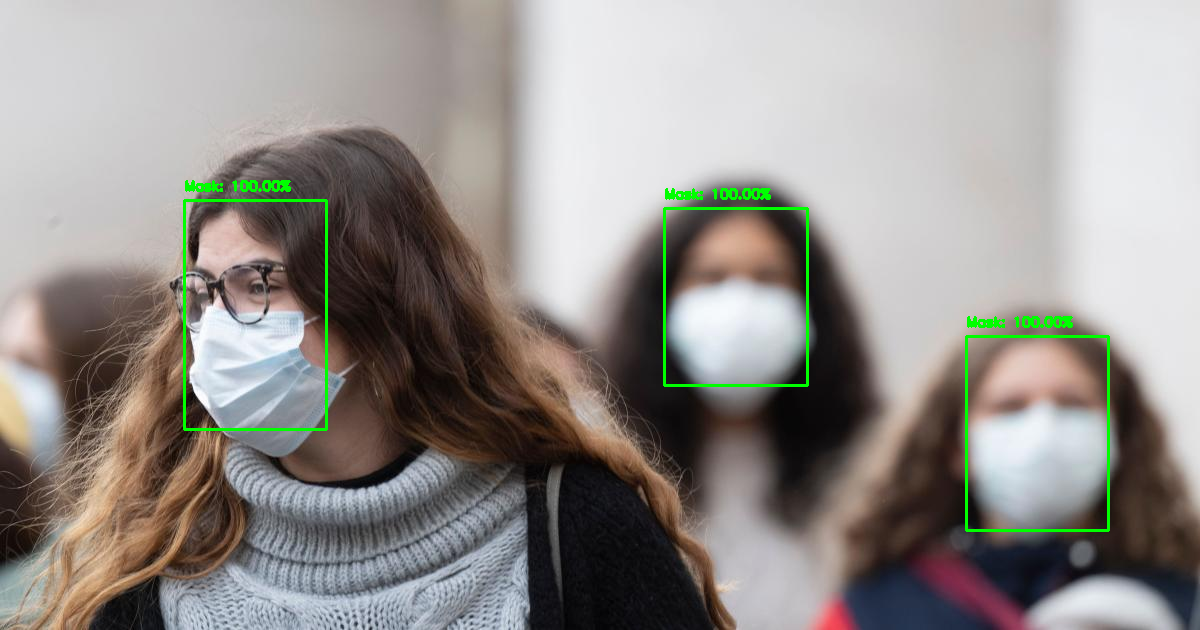

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import argparse
from google.colab.patches import cv2_imshow
from natsort import natsorted, ns
input_file_path = "/content/drive/My Drive/Colab Notebooks/dataset-face-mask/dataset/test/masked/with_mask434.jpg"
print("[INFO] loading face detector model...")
prototxtPath = "/content/drive/My Drive/Colab Notebooks/deploy.prototxt"
weightsPath = "/content/drive/My Drive/Colab Notebooks/res10_300x300_ssd_iter_140000.caffemodel"
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector
print("[INFO] loading face mask detector model...")
model = load_model("//content/drive/My Drive/Colab Notebooks/Covid19Facemask.h5")
def process_images(input_file_path):
  # load the input imag
  # dimensions
  image = cv2.imread(input_file_path)
  (h, w) = image.shape[:2]
  # construct a blob from the image
  blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
 # pass the blob through the network and obtain the face detections
  print("[INFO] computing face detections...")
  net.setInput(blob)
  detections = net.forward()
  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.5:
      # compute the (x, y)-coordinates of the bounding box for
      # the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      # ensure the bounding boxes fall within the dimensions of
      # the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
      # extract the face ROI, convert it from BGR to RGB channel
      # ordering, resize it to 150x150, and preprocess it
      face = image[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (64, 64))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
      # pass the face through the model to determine if the face
      # has a mask or not
      (mask, withoutMask) = model.predict(face)[0]
      # determine the class label and color we'll use to draw
      # the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
   # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
      # display the label and bounding box rectangle on the output
      # frame
      cv2.putText(image, label, (startX, startY - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
  # show the output image
  save_path = input_file_path.split(".",1)
  cv2_imshow(image)
#start the process
process_images(input_file_path)